In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
import random
from tqdm import tqdm

# --- Setup ---
plt.style.use('seaborn-v0_8-whitegrid')
data_dir = Path.cwd() / "data"
# 1. 스크립트 임포트
from data.prepare_datasets import PrepareDataset
from data_loader.data_loaders import BUSDataLoader


In [2]:
print("--- STEP 1: Preparing CSV files ---")

# 클래스를 생성하면 내부적으로 모든 경로를 설정합니다.
preparer = PrepareDataset()

# 처리할 데이터셋 이름만 리스트로 전달합니다.
# 'data' 폴더에 busi.csv, bus_uc.csv 등이 생성됩니다.
preparer.prepare_selected(['yap','busi', 'uc','uclm','busbra'])

print("\n✅ CSV file preparation complete.")

--- STEP 1: Preparing CSV files ---
Processing dataset: 'yap'...
  -> Saved to /home/army/workspace/Awesome_Segmentation_in_Medical/data/yap2018.csv
Processing dataset: 'busi'...
  -> Saved to /home/army/workspace/Awesome_Segmentation_in_Medical/data/busi.csv
Processing dataset: 'uc'...
  -> Saved to /home/army/workspace/Awesome_Segmentation_in_Medical/data/bus_uc.csv
Processing dataset: 'uclm'...
  -> Saved to /home/army/workspace/Awesome_Segmentation_in_Medical/data/bus_uclm.csv
Processing dataset: 'busbra'...
  -> Saved to /home/army/workspace/Awesome_Segmentation_in_Medical/data/busbra.csv

✅ CSV file preparation complete.


In [3]:
# --- Load All CSVs ---
csv_files = {
    'busi': 'busi.csv', 'yap': 'yap2018.csv', 'uc': 'bus_uc.csv',
    'uclm': 'bus_uclm.csv', 'busbra': 'busbra.csv'
}
dfs = {name: pd.read_csv(data_dir / fname) for name, fname in csv_files.items() if (data_dir / fname).exists()}
all_df = pd.concat(dfs.values(), ignore_index=True) if dfs else pd.DataFrame()
print(f"✅ Loaded {len(dfs)} datasets with {len(all_df)} total samples.")

# --- Filter out 'test' split for analysis ---
train_dfs = {name: df[df['split'] != 'test'].copy() for name, df in dfs.items()}
all_train_df = all_df[all_df['split'] != 'test'].copy()
print(f"✅ Created training/validation sets with {len(all_train_df)} total samples.")

✅ Loaded 5 datasets with 4312 total samples.
✅ Created training/validation sets with 3448 total samples.


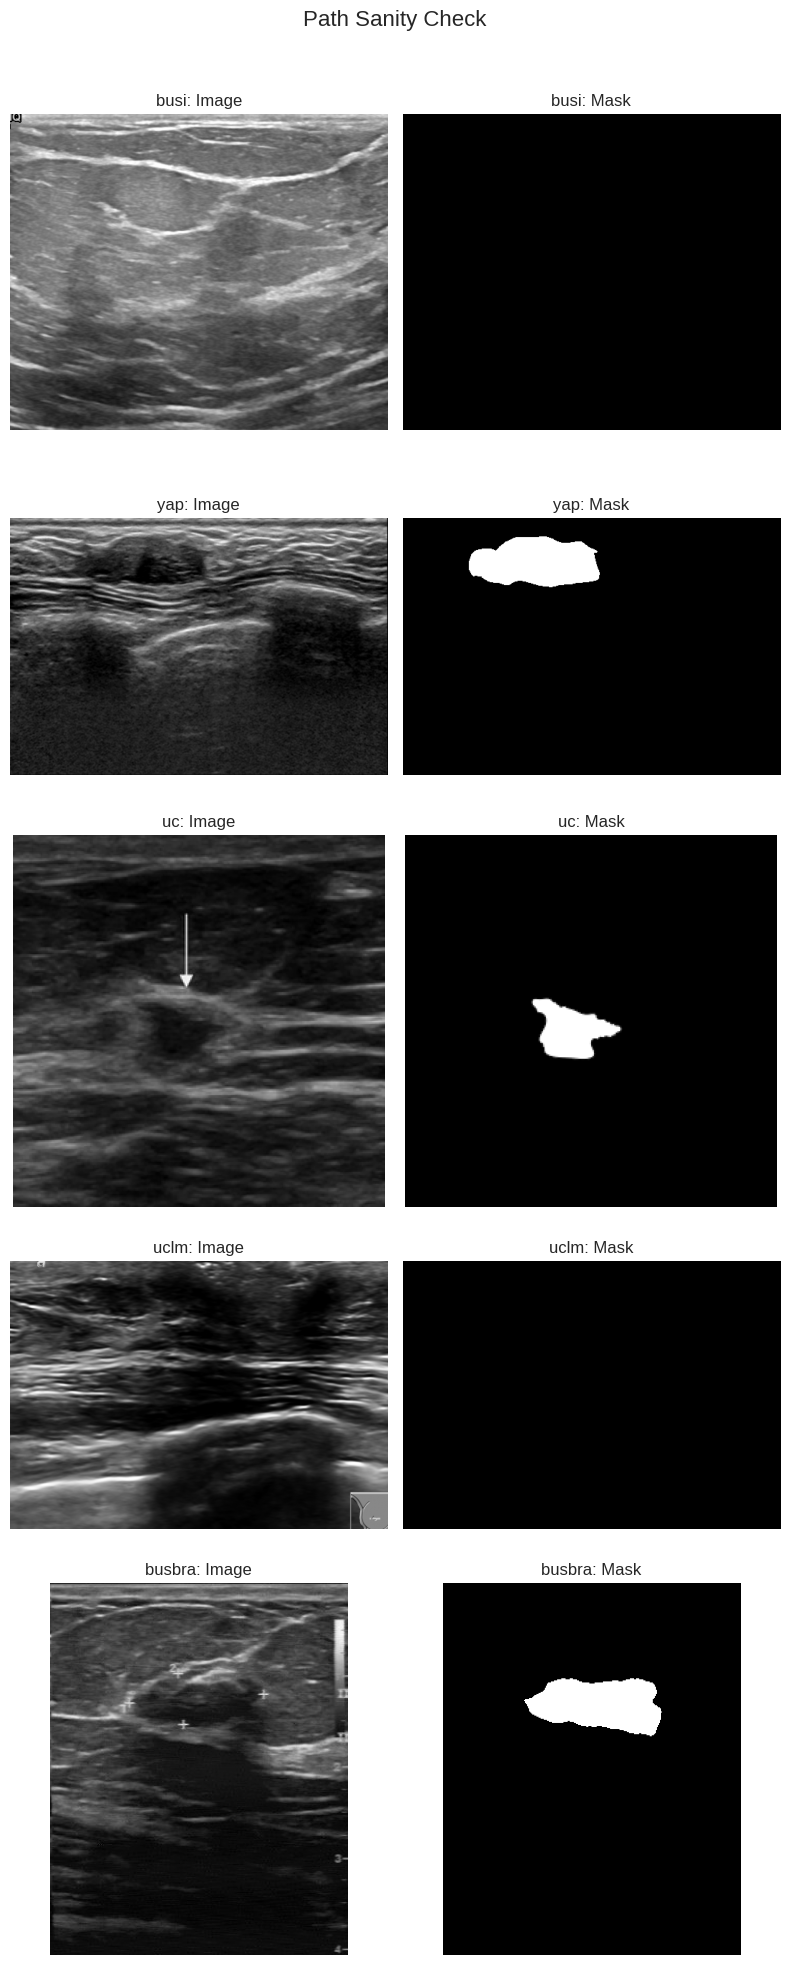

In [4]:
def check_paths_visually(dataframes_dict):
    """Visually verify image and mask paths for a sample from each dataset."""
    fig, axes = plt.subplots(len(dataframes_dict), 2, figsize=(8, len(dataframes_dict) * 4))
    fig.suptitle("Path Sanity Check", fontsize=16)

    for i, (name, df) in enumerate(dataframes_dict.items()):
        sample = df.sample(1).iloc[0]
        try:
            img = cv2.imread(sample['image_path'], cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(sample['mask_path'], cv2.IMREAD_GRAYSCALE)

            axes[i, 0].imshow(img, cmap='gray')
            axes[i, 0].set_title(f"{name}: Image")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask, cmap='gray')
            axes[i, 1].set_title(f"{name}: Mask")
            axes[i, 1].axis('off')
        except Exception as e:
            print(f"Error loading sample for {name}: {e}")
            
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

check_paths_visually(train_dfs)

🔎 Distribution for 'busi' dataset
--- Fold Distribution ---
split
1    125
2    125
3    125
4    125
5    124
Name: count, dtype: int64

--- Label Distribution ---
label
benign       350
malignant    168
normal       106
Name: count, dtype: int64


🔎 Distribution for 'yap' dataset
--- Fold Distribution ---
split
1    26
2    26
3    26
4    26
5    26
Name: count, dtype: int64

--- Label Distribution ---
label
benign       87
malignant    43
Name: count, dtype: int64


🔎 Distribution for 'uc' dataset
--- Fold Distribution ---
split
1    130
2    130
3    130
4    129
5    129
Name: count, dtype: int64

--- Label Distribution ---
label
malignant    362
benign       286
Name: count, dtype: int64


🔎 Distribution for 'uclm' dataset
--- Fold Distribution ---
split
1    110
2    109
3    109
4    109
5    109
Name: count, dtype: int64

--- Label Distribution ---
label
normal       335
benign       139
malignant     72
Name: count, dtype: int64


🔎 Distribution for 'busbra' dataset
--- Fold

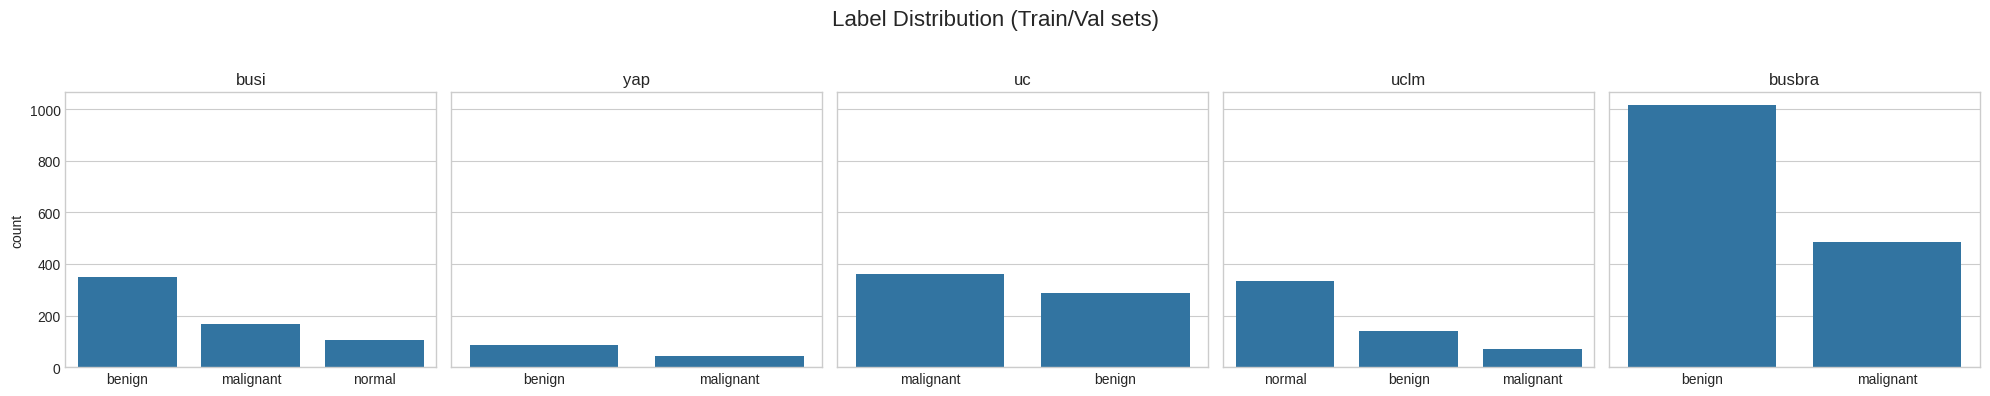

In [5]:
for name, df in train_dfs.items():
    print("=" * 50)
    print(f"🔎 Distribution for '{name}' dataset")
    print("=" * 50)
    
    # 1. Samples per fold
    print("--- Fold Distribution ---")
    print(df['split'].value_counts().sort_index())
    
    # 2. Samples per label
    print("\n--- Label Distribution ---")
    print(df['label'].value_counts())
    print("\n")

# Visualize label distribution
fig, axes = plt.subplots(1, len(train_dfs), figsize=(20, 4), sharey=True)
fig.suptitle('Label Distribution (Train/Val sets)', fontsize=16)
for i, (name, df) in enumerate(train_dfs.items()):
    order = df['label'].value_counts().index
    sns.countplot(x='label', data=df, ax=axes[i], order=order)
    axes[i].set_title(name)
    axes[i].set_xlabel('')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


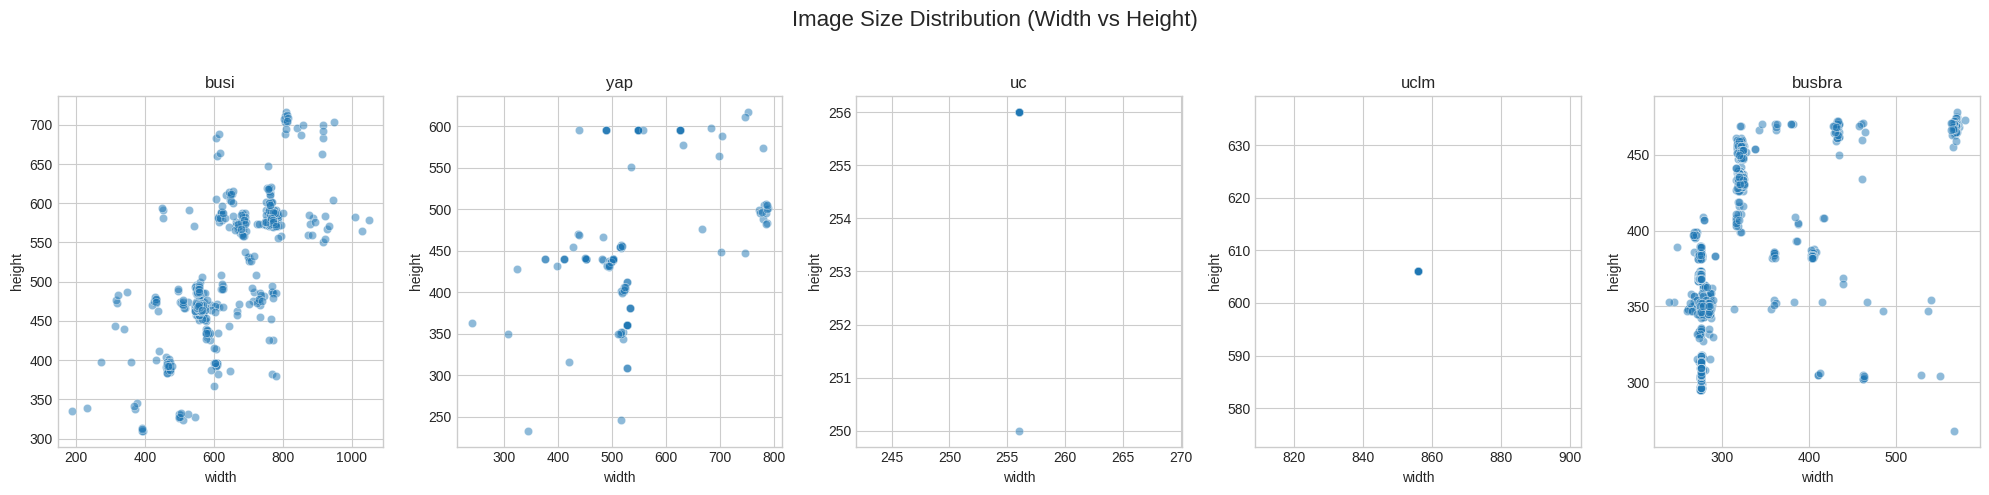

In [6]:
fig, axes = plt.subplots(1, len(train_dfs), figsize=(20, 5))
fig.suptitle('Image Size Distribution (Width vs Height)', fontsize=16)

for i, (name, df) in enumerate(train_dfs.items()):
    sns.scatterplot(x='width', y='height', data=df, ax=axes[i], alpha=0.5)
    axes[i].set_title(name)
    axes[i].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Accumulating masks: 100%|██████████| 1500/1500 [00:00<00:00, 3368.31it/s]


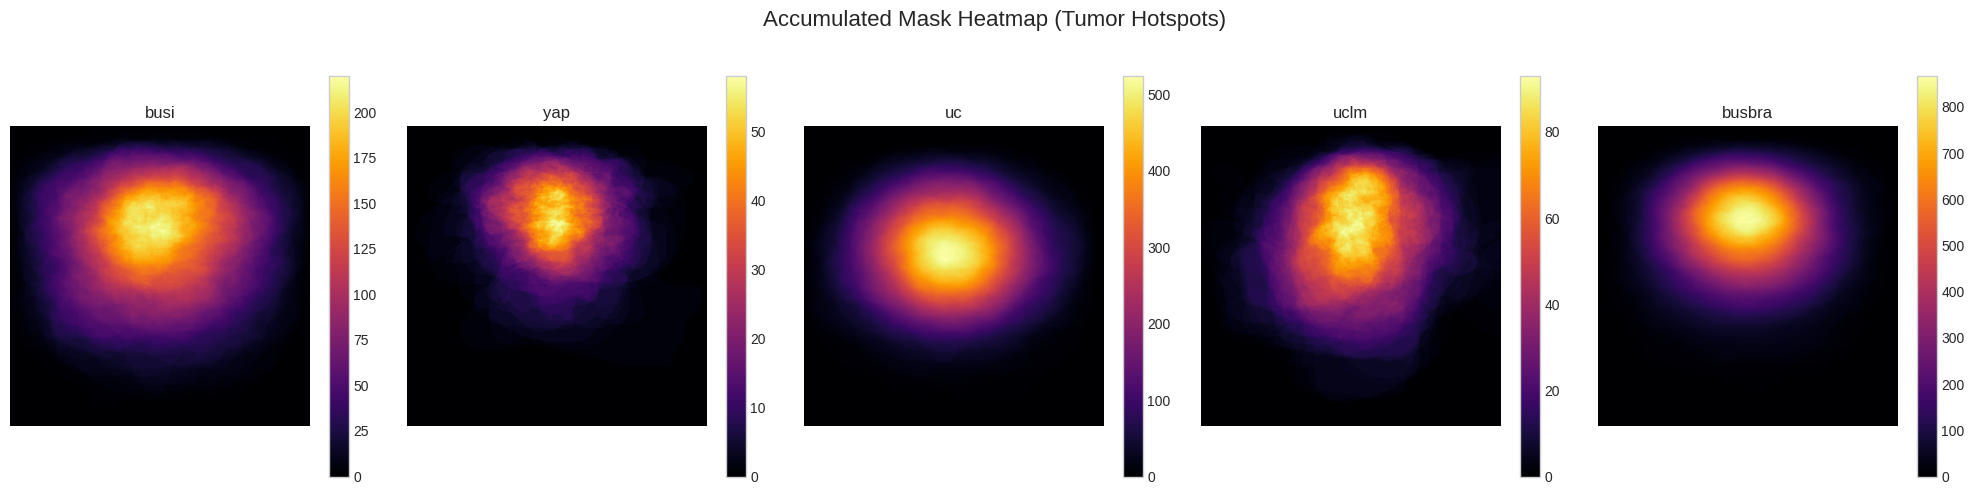

In [7]:
def create_mask_heatmap(df, target_size=(256, 256)):
    """Creates an accumulated heatmap from all masks in a dataframe."""
    accumulator = np.zeros(target_size, dtype=np.float32)
    
    for mask_path in tqdm(df['mask_path'].dropna(), desc=f"Accumulating masks"):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
            accumulator += mask_resized / 255.0 # Normalize and add
            
    return accumulator

fig, axes = plt.subplots(1, len(train_dfs), figsize=(20, 5))
fig.suptitle('Accumulated Mask Heatmap (Tumor Hotspots)', fontsize=16)

for i, (name, df) in enumerate(train_dfs.items()):
    heatmap = create_mask_heatmap(df)
    ax = axes[i]
    if heatmap.max() > 0:
        im = ax.imshow(heatmap, cmap='inferno')
        fig.colorbar(im, ax=ax)
    else:
        ax.text(0.5, 0.5, 'No Masks', ha='center', va='center')
    ax.set_title(name)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Aggregating pixels for busbra: 100%|██████████| 50/50 [00:00<00:00, 202.83it/s]


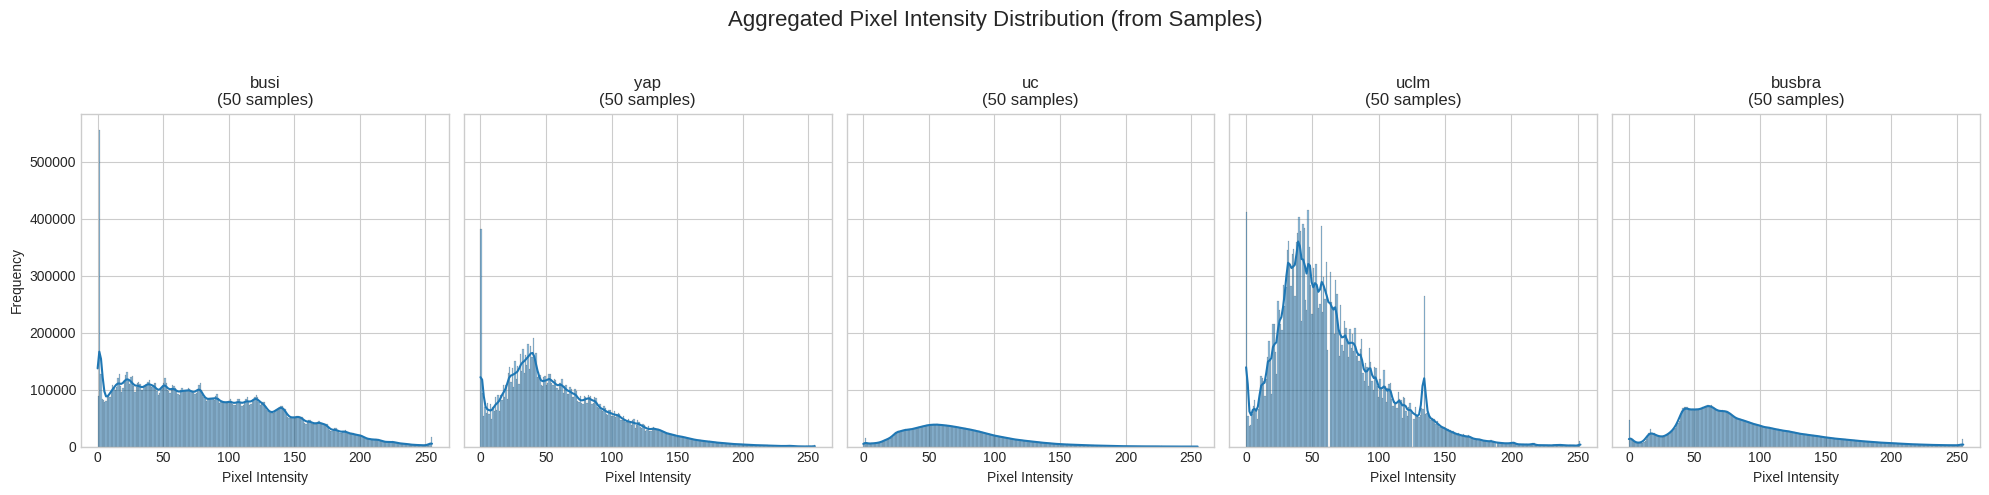

In [17]:
def plot_sampled_aggregated_intensity(df, ax, title, n_samples=50):
    """
    Aggregates pixels from a SAMPLE of images in a dataframe
    and plots a single representative histogram.
    """
    # Ensure sample size is not larger than the dataframe itself
    sample_size = min(n_samples, len(df))
    if sample_size == 0:
        ax.set_title(f"{title}\n(No data)")
        return
        
    samples = df.sample(sample_size, random_state=42) # Use random_state for reproducibility
    
    all_pixels = []
    # Use tqdm to show progress
    for img_path in tqdm(samples['image_path'], desc=f"Aggregating pixels for {title}"):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            all_pixels.extend(img.flatten())
    
    # Plot the aggregated histogram from the sample
    if all_pixels:
        sns.histplot(all_pixels, bins=256, ax=ax, kde=True)
        ax.set_title(f"{title}\n({sample_size} samples)")
    else:
        ax.set_title(f"{title}\n(Could not load samples)")
        
    ax.set_xlabel("Pixel Intensity")
    ax.grid(True)

# --- Create subplots for each dataset ---
fig, axes = plt.subplots(1, len(train_dfs), figsize=(20, 5), sharey=True)
fig.suptitle('Aggregated Pixel Intensity Distribution (from Samples)', fontsize=16)

# Set a common y-label for the first subplot
axes[0].set_ylabel("Frequency")

for i, (name, df) in enumerate(train_dfs.items()):
    # You can change the number of samples by adjusting n_samples
    plot_sampled_aggregated_intensity(df, axes[i], name, n_samples=50)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Calculating mask ratios for 'busi'...


Processing busi: 100%|██████████| 624/624 [00:00<00:00, 1569.71it/s]


Calculating mask ratios for 'yap'...


Processing yap: 100%|██████████| 130/130 [00:00<00:00, 1917.46it/s]


Calculating mask ratios for 'uc'...


Processing uc: 100%|██████████| 648/648 [00:00<00:00, 2185.73it/s]


Calculating mask ratios for 'uclm'...


Processing uclm: 100%|██████████| 546/546 [00:00<00:00, 1177.16it/s]


Calculating mask ratios for 'busbra'...


Processing busbra: 100%|██████████| 1500/1500 [00:00<00:00, 4952.29it/s]


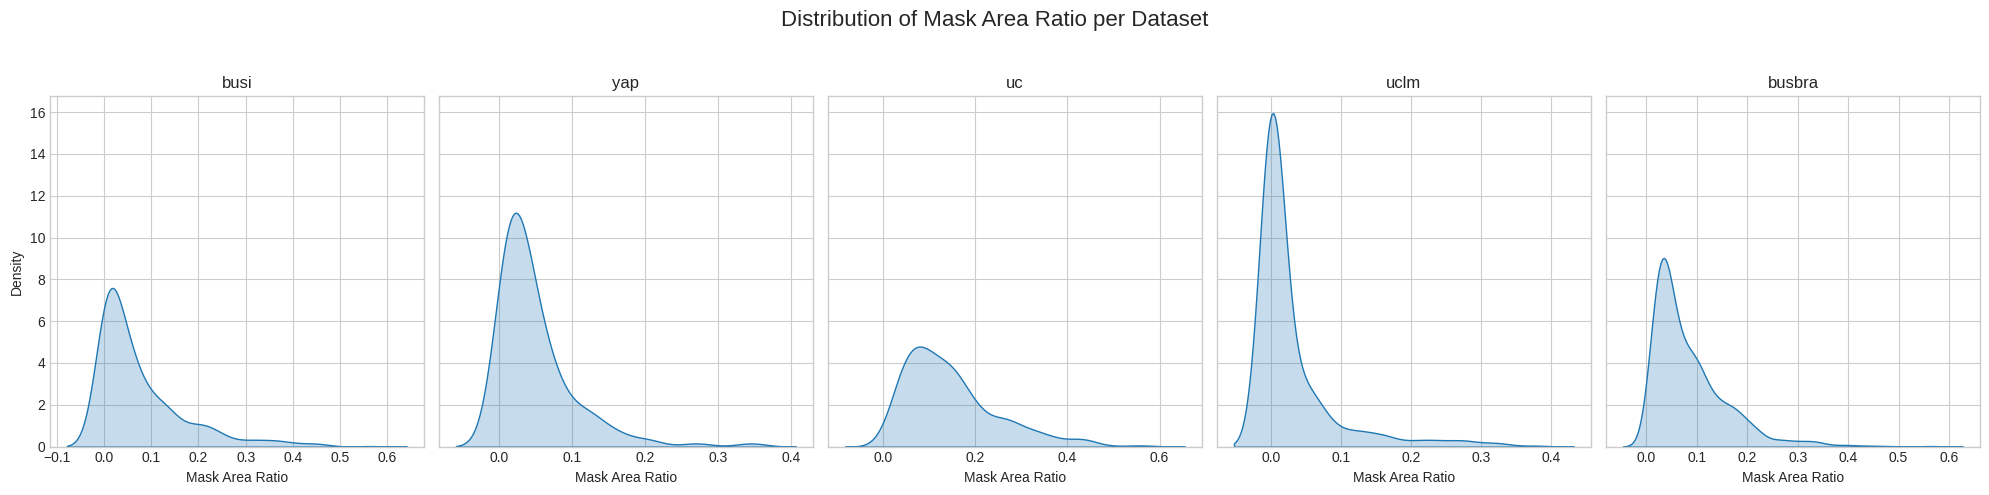

In [16]:
from tqdm import tqdm

# A helper function to calculate ratio for a single row
def get_mask_ratio(row):
    """Helper function to calculate mask area ratio for one row."""
    if pd.notna(row['mask_path']):
        mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            # Avoid division by zero for images with no area
            if row['width'] > 0 and row['height'] > 0:
                return np.sum(mask > 0) / (row['width'] * row['height'])
    return np.nan # Return NaN if no mask or no area

# --- STEP 1: Calculate mask ratio for each dataframe ---
# This loop only performs the calculation.
for name, df in train_dfs.items():
    print(f"Calculating mask ratios for '{name}'...")
    tqdm.pandas(desc=f"Processing {name}")
    df['mask_ratio'] = df.progress_apply(get_mask_ratio, axis=1)

# --- STEP 2: Visualize the distributions in separate subplots ---
# This part handles the plotting.
fig, axes = plt.subplots(1, len(train_dfs), figsize=(20, 5), sharey=True)
fig.suptitle("Distribution of Mask Area Ratio per Dataset", fontsize=16)

for i, (name, df) in enumerate(train_dfs.items()):
    ax = axes[i]
    # Plot only the current dataframe's data on its dedicated subplot
    sns.kdeplot(data=df['mask_ratio'].dropna(), ax=ax, fill=True)
    ax.set_title(name)
    ax.set_xlabel("Mask Area Ratio")

# Set a common y-label
axes[0].set_ylabel("Density")
    
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


/tmp/ipykernel_3622870/146247462.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='dataset', y='aspect_ratio', data=aspect_ratio_df, palette='coolwarm', inner='quartile')


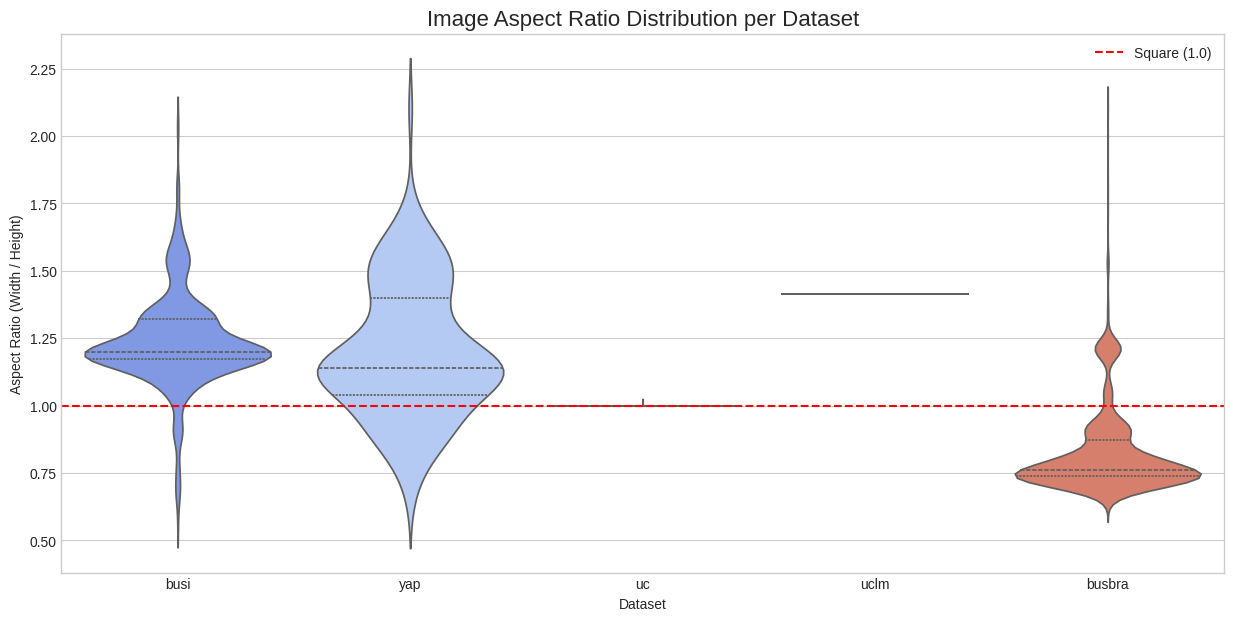

In [11]:
# Calculate aspect ratio for all datasets
for name, df in train_dfs.items():
    # To avoid division by zero
    df['aspect_ratio'] = df['width'] / df['height'].replace(0, 1)

# Combine aspect ratios into a single DataFrame for plotting with seaborn
aspect_ratio_df = pd.concat([
    pd.DataFrame({'dataset': name, 'aspect_ratio': df['aspect_ratio']}) 
    for name, df in train_dfs.items()
], ignore_index=True)

# Visualize with a violin plot
plt.figure(figsize=(15, 7))
sns.violinplot(x='dataset', y='aspect_ratio', data=aspect_ratio_df, palette='coolwarm', inner='quartile')
plt.axhline(1.0, color='red', linestyle='--', label='Square (1.0)') # A line for square aspect ratio
plt.title("Image Aspect Ratio Distribution per Dataset", fontsize=16)
plt.xlabel("Dataset")
plt.ylabel("Aspect Ratio (Width / Height)")
plt.legend()
plt.show()

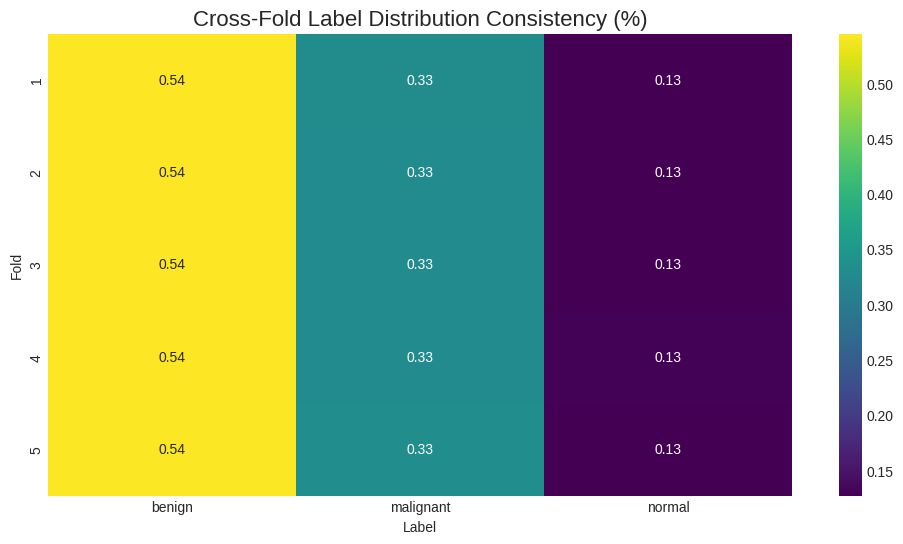

In [12]:
if 'all_train_df' in locals():
    # Create a cross-tabulation of splits vs labels
    contingency_table = pd.crosstab(
        all_train_df['split'], 
        all_train_df['label'],
        normalize='index' # Normalize to see percentages within each fold
    )
    
    # Exclude 'test' split if it's still present, focusing on folds 1-5
    contingency_table = contingency_table.drop('test', errors='ignore')

    plt.figure(figsize=(12, 6))
    sns.heatmap(contingency_table, annot=True, fmt='.2f', cmap='viridis')
    plt.title('Cross-Fold Label Distribution Consistency (%)', fontsize=16)
    plt.xlabel('Label')
    plt.ylabel('Fold')
    plt.show()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2

from data_loader.data_loaders import BUSDataLoader, get_default_transform

# 데이터프레임 불러오기
df = pd.read_csv('./data/busi.csv')

# 증강 포함 transform
transform_aug = get_default_transform(target_size=256, padding_color=0, augment=True)
# 증강 없는 transform (전처리만)
transform_noaug = get_default_transform(target_size=1024, padding_color=0, augment=False)

# DataLoader (증강)
loader_aug = BUSDataLoader(df, batch_size=1, split='3', transform=transform_aug)
# DataLoader (증강X)
loader_noaug = BUSDataLoader(df, batch_size=1, split='3', transform=transform_noaug)

# 같은 인덱스의 샘플을 가져오기 위해 idx=0 사용
row = df[df['split'] == '3'].iloc[0]
image = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
mask = None
if pd.notnull(row.get('mask_path', None)):
    mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)

# 증강 없이 전처리만 적용
noaug = transform_noaug(image=image, mask=mask)
image_noaug = noaug['image']
mask_noaug = noaug['mask']

# 증강 적용
aug = transform_aug(image=image, mask=mask)
image_aug = aug['image']
mask_aug = aug['mask']

# 시각화
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(image_noaug, cmap='gray')
axs[0, 0].set_title('Original + Preprocess')
axs[0, 0].axis('off')
axs[0, 1].imshow(mask_noaug, cmap='gray')
axs[0, 1].set_title('Mask (Preprocess)')
axs[0, 1].axis('off')
axs[1, 0].imshow(image_aug, cmap='gray')
axs[1, 0].set_title('Augmented Image')
axs[1, 0].axis('off')
axs[1, 1].imshow(mask_aug, cmap='gray')
axs[1, 1].set_title('Augmented Mask')
axs[1, 1].axis('off')
plt.tight_layout()
plt.show()

ImportError: cannot import name 'get_default_transform' from 'data_loader.data_loaders' (/home/army/workspace/Awesome_Segmentation_in_Medical/data_loader/data_loaders.py)